# **Sale Price Study**

## Objectives

Answer business requirement 1:
* The client is interested in understanding the relationship between the attributes of a house and its market value as a consequence.
Therefore, this notebook will demonstrate a correlation study and will display data visualisations in the form of graphs.

## Inputs

* outputs/datasets/collection/house_price_records.csv 

## Outputs

* Generate code and plots/graphs that answers business requirement 1 and can be used to build the Streamlit App 

## Additional 

* 
 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

# Load Data

In [5]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
    )
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

We will now familiarise ourselves with the dataset

In [6]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation study

First we will explore the missing data

In [7]:
vars_with_missing_data = df[df.columns[df.isna().sum() > 0]]
vars_with_missing_data

,2ndFlrSF,BedroomAbvGr,BsmtFinType1,EnclosedPorch,GarageFinish,GarageYrBlt,LotFrontage,MasVnrArea,WoodDeckSF
0,854.0,3.0,GLQ,0.0,RFn,2003.0,65.0,196.0,0.0
1,0.0,3.0,ALQ,NaN,RFn,1976.0,80.0,0.0,NaN
2,866.0,3.0,GLQ,0.0,RFn,2001.0,68.0,162.0,NaN
3,NaN,NaN,ALQ,NaN,Unf,1998.0,60.0,0.0,NaN
4,NaN,4.0,GLQ,0.0,RFn,2000.0,84.0,350.0,NaN
...,...,...,...,...,...,...,...,...,...
1455,694.0,3.0,Unf,NaN,RFn,1999.0,62.0,0.0,0.0
1456,0.0,NaN,ALQ,NaN,Unf,1978.0,85.0,119.0,NaN
1457,1152.0,4.0,GLQ,NaN,RFn,1941.0,66.0,0.0,NaN
1458,0.0,2.0,NaN,112.0,Unf,1950.0,68.0,0.0,NaN


We will impute the missing values in the data with the most common value for each column.

In [8]:
catagorical_missing_var = (vars_with_missing_data
                    .columns[vars_with_missing_data.dtypes == 'object']
                    .to_list())
catagorical_missing_var

['BsmtFinType1', 'GarageFinish']

We will use catagorical Imputer to fill in the missing values 

In [9]:
from feature_engine.imputation import CategoricalImputer
categorical_imputer = CategoricalImputer(imputation_method='frequent',
                                         variables=catagorical_missing_var)
df = categorical_imputer.fit_transform(df)

In [10]:
df.filter(catagorical_missing_var).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtFinType1  1460 non-null   object
 1   GarageFinish  1460 non-null   object
dtypes: object(2)
memory usage: 22.9+ KB


We will now use OneHotEncoder to complete the transformation for the missing values

In [11]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(3)

(1460, 40)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageYrBlt,GrLivArea,LotArea,...,BsmtFinType1_None,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Fin,GarageFinish_None,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.0,706,150,0.0,548,2003.0,1710,8450,...,0,0,1,0,0,0,1,0,0,0
1,1262,0.0,3.0,978,284,NaN,460,1976.0,1262,9600,...,0,0,1,0,0,0,0,1,0,0
2,920,866.0,3.0,486,434,0.0,608,2001.0,1786,11250,...,0,0,1,0,0,0,1,0,0,0


We will use .corr() for spearman and pearson and investigate the top 10 correlations

In [12]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
GarageYrBlt       0.593788
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
Name: SalePrice, dtype: float64

In [13]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
GarageYrBlt       0.486362
Name: SalePrice, dtype: float64

The above figures show strong correlations between the variables and the 'SalePrice'.
We will look further at the top correlations:

In [14]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

In [15]:
vars_to_study = ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

# EDA on selected variables

In [16]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head(3)

,1stFlrSF,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,856,548,1710,7,856,2003,208500
1,1262,460,1262,6,1262,1976,181500
2,920,608,1786,7,920,2001,223500


# Data Visualisation 

We will map plots below to gain insights regarding the high scoring variables and their relationship to the 'SalePrice' and save the outputs.
We will use feature_engine discretiser and in particular the equal frequancy method.

In [17]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
discretiser = EqualFrequencyDiscretiser(q=6, variables=['SalePrice'])
discretiser.fit(df_eda)
df_eda = discretiser.transform(df_eda)
df_eda

,1stFlrSF,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,856,548,1710,7,856,2003,4
1,1262,460,1262,6,1262,1976,3
2,920,608,1786,7,920,2001,4
3,961,642,1717,7,756,1915,2
4,1145,836,2198,8,1145,2000,5
...,...,...,...,...,...,...,...
1455,953,460,1647,6,953,1999,3
1456,2073,500,2073,6,1542,1978,4
1457,1188,252,2340,7,1152,1941,5
1458,1078,240,1078,5,1078,1950,2


In [18]:
discretiser.binner_dict_['SalePrice']

[-inf, 118500.0, 139700.0, 163000.0, 190000.0, 241416.66666666663, inf]

We will now create a map to replace the 'SalePrice' variable with more informative levels

In [20]:
labels = discretiser.binner_dict_['SalePrice']
n_factor = len(labels)-1
labels_map = {}

for n in range(0, n_factor):
    if n == 0:
        labels_map[n] = f"< {labels[1]}"
    elif n < n_factor - 1:
        labels_map[n] = f"+{labels[n]}"
    else:
        labels_map[n] = f"{labels[n]} to - {labels[n+1]}"

labels_map

{0: '< 118500.0',
 1: '+118500.0',
 2: '+139700.0',
 3: '+163000.0',
 4: '+190000.0',
 5: '241416.66666666663 to - inf'}

Now we have the 'SalePrice' ranges and thus have 'bins' which the properties can be allocated to, as per their sale price.
Lets view these in a dataFrame format:

In [21]:
df_eda['SalePrice'] = df_eda['SalePrice'].replace(labels_map)
df_eda

,1stFlrSF,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,856,548,1710,7,856,2003,+190000.0
1,1262,460,1262,6,1262,1976,+163000.0
2,920,608,1786,7,920,2001,+190000.0
3,961,642,1717,7,756,1915,+139700.0
4,1145,836,2198,8,1145,2000,241416.66666666663 to - inf
...,...,...,...,...,...,...,...
1455,953,460,1647,6,953,1999,+163000.0
1456,2073,500,2073,6,1542,1978,+190000.0
1457,1188,252,2340,7,1152,1941,241416.66666666663 to - inf
1458,1078,240,1078,5,1078,1950,+139700.0


We will plot histograms to visualise the above data. This will make it easier to digest the above data. 

In [22]:
hue_order = labels_map.values()
list(hue_order)

['< 118500.0',
 '+118500.0',
 '+139700.0',
 '+163000.0',
 '+190000.0',
 '241416.66666666663 to - inf']

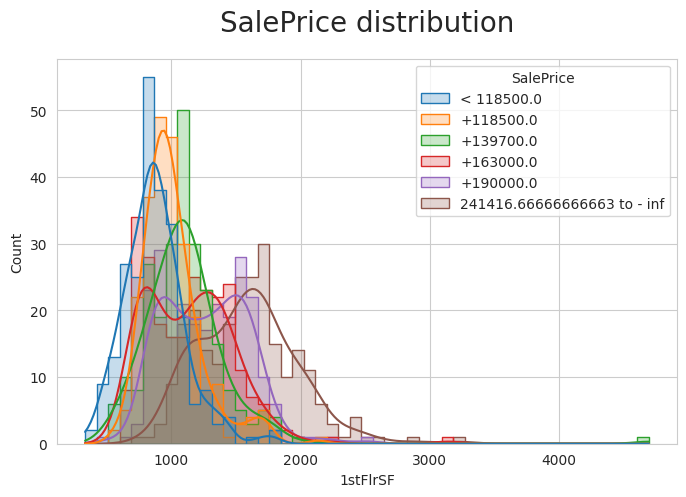

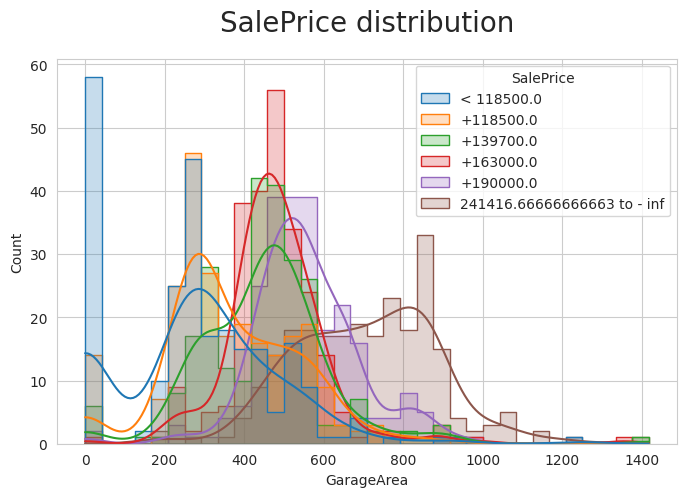

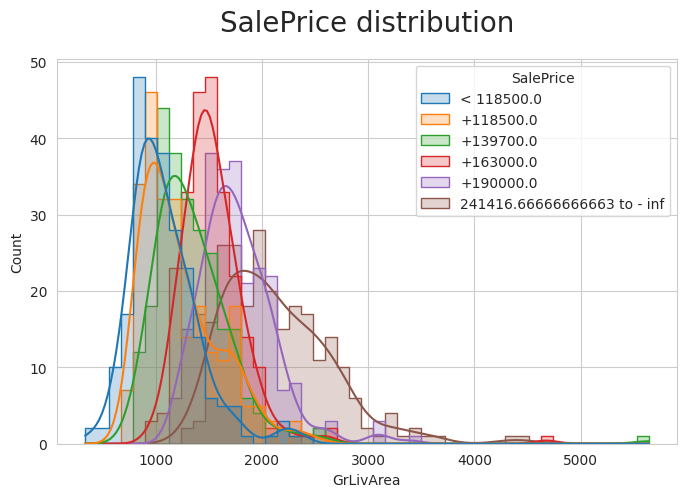

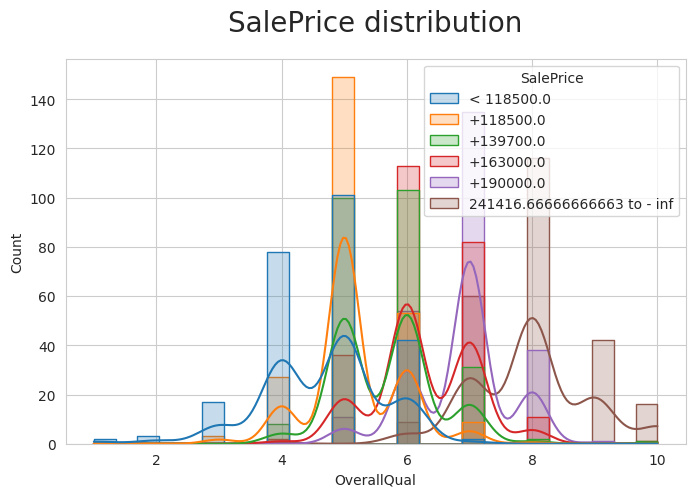

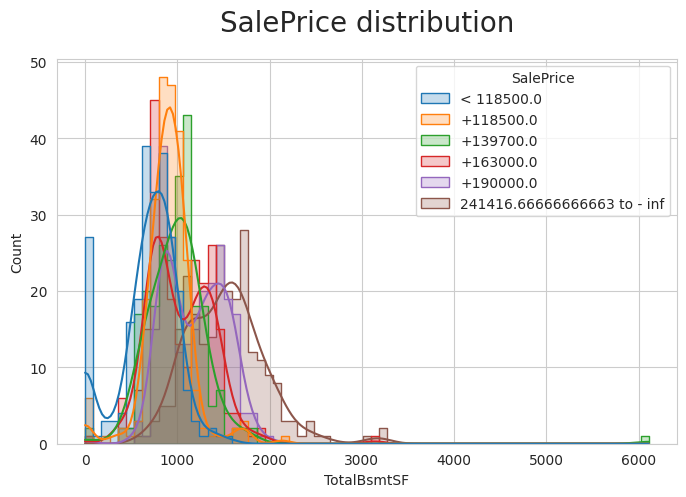

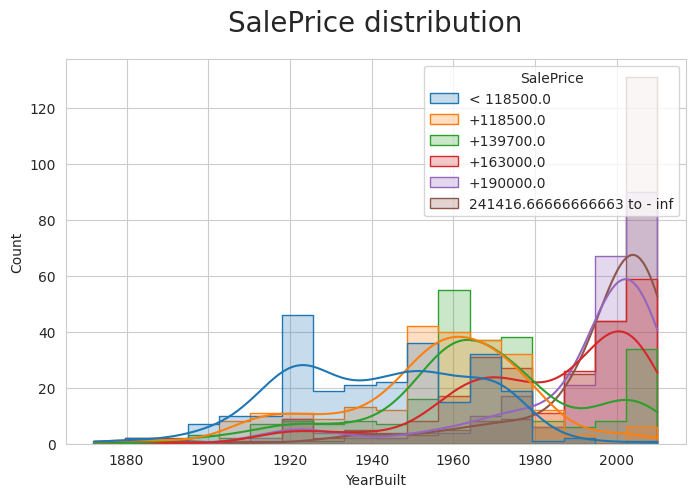

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def plot_numerical(df, col, target_var, hue_order):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue=target_var, hue_order=hue_order, kde=True,
                 element="step")
    plt.title(f"{target_var} distribution", fontsize=20, y=1.05)
    plt.show()


target_var = 'SalePrice'
for col in ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']:
    plot_numerical(df_eda, col, target_var, hue_order)
    print("\n\n")

We will delve further by mapping the variables of our hypothesis againstthe sale price individually. 

In [27]:
df_pearson = df.corr(method='pearson')['SalePrice'].filter(['GrLivArea'])
df_pearson

GrLivArea    0.708624
Name: SalePrice, dtype: float64

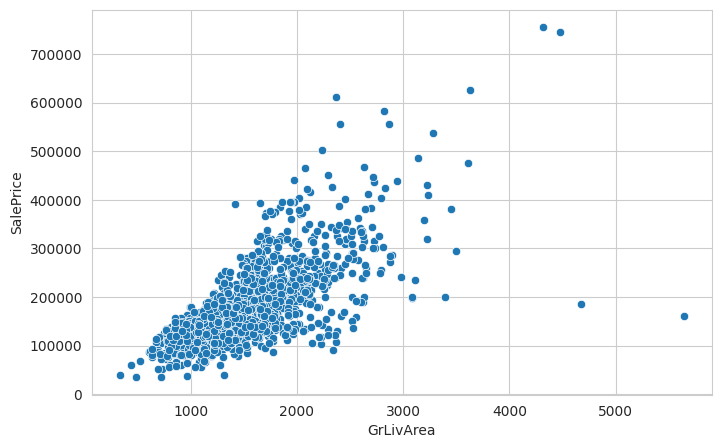

In [29]:
x, y = 'GrLivArea', 'SalePrice'
fig, axes = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df, x=x, y=y)
plt.show()

The pearson correlation score points towards the fact that the size of the house has a relatively high correlation to the value of the house. 
The scatter plot and histogram we mapped earlier, both illustrate that as the property size increases, so does the sale price. This supports our first hypothesis. 

We will explore the second third hypothesis regarding house age against the sale price. 

In [34]:
df_pearson = df.corr(method='pearson')['SalePrice'].filter(['YearBuilt'])
df_pearson

YearBuilt    0.522897
Name: SalePrice, dtype: float64

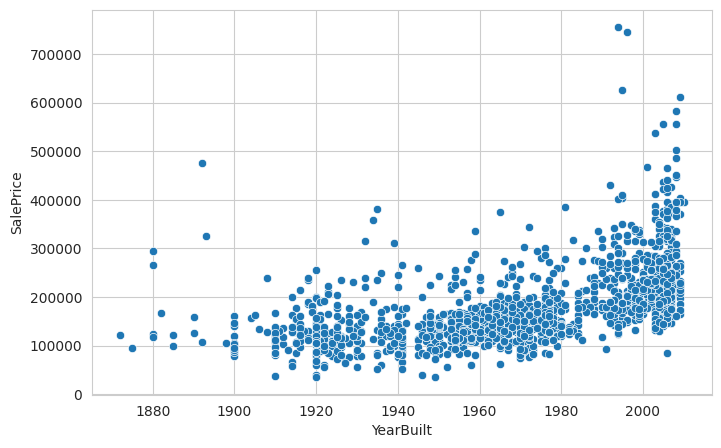

In [35]:
x, y = 'YearBuilt', 'SalePrice'
fig, axes = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df, x=x, y=y)
plt.show()

Here we can see the correlation does exist, but is not as strong or clear. For example, the most expensive property may be the most recent, however there are instances where a property built in 1920 can be valued the same as a property built in more recent times.

We will explore the third hypothesis by examing the overall quality of the property against the sale price. 

In [30]:
df_pearson = df.corr(method='pearson')['SalePrice'].filter(['OverallQual'])
df_pearson

OverallQual    0.790982
Name: SalePrice, dtype: float64

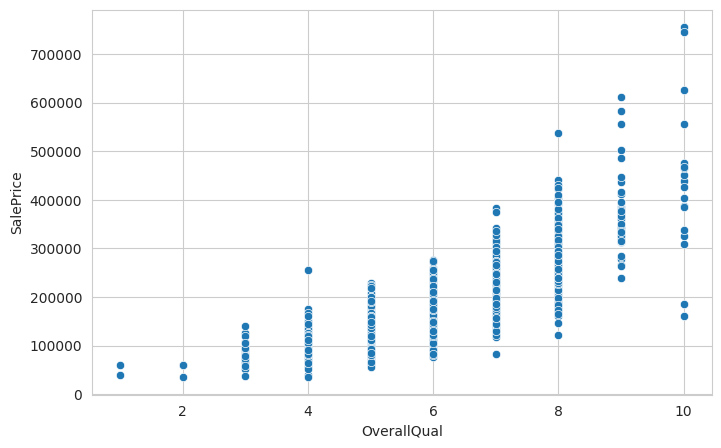

In [31]:
x, y = 'OverallQual', 'SalePrice'
fig, axes = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df, x=x, y=y)
plt.show()

Clearly indicates that house quality is key to  increasing the house price and the correlation score is also very high. 

# Conclusions and Next Steps 

The correlations and plots interpretation converge

* House lot size has a big impact on house price
* Expand on observations from above graphs 
*
*